#Eduardo Contreras Bohórquez
##6 de marzo de 2023


##Parte 2: Practica con datos

---

##Estrategia de solución:  
Se usó un modelo de texto preentrenado para análisis del sentimiento, el cual se puede obtener en el sitio web de Hugging Face: 
https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english

Este modelo es una adaptación del modelo clásico BERT al cual le hicieron fine-tuning con un dataset de comentarios a películas para la tarea de análisis de sentimiento, produciendo para cada comentario una clasificación de sentimiento positivo o negativo junto con un puntaje.

Las opiniones sobre películas o sobre hoteles se pueden considerar similares por lo tanto en este notebook se explora la posibilidad de aplicar un modelo preentrenado a un nuevo conjunto de datos similar.

### Lectura de datos

In [2]:
import pandas as pd
csv = "/content/drive/MyDrive/Colab Notebooks/COMP/tripadvisor_hotel_reviews.csv"
dat = pd.read_csv(csv)

### Uso de modelo preentrenado tipo BERT para análisis de sentimiento

In [40]:
!pip install transformers
from transformers import pipeline
pipe = pipeline(model="distilbert-base-uncased-finetuned-sst-2-english")
pipe("This restaurant is awesome")

[{'label': 'POSITIVE', 'score': 0.9998743534088135}]

In [60]:
from tqdm.auto import tqdm 
tqdm.pandas()
#Se cortan los textos más largos para que quepan en la capa de entrada del modelo que sorporta máximo 512 tokens.
reviews = dat.Review.progress_apply(lambda s: s[:1900]) 
sentiments = reviews.progress_apply(pipe)

  0%|          | 0/20491 [00:00<?, ?it/s]

  0%|          | 0/20491 [00:00<?, ?it/s]

In [80]:
res = [s[0] for s in sentiments]
sentimentsdf = pd.DataFrame(res)
#sentimentsdf.to_csv("/content/drive/MyDrive/Colab Notebooks/COMP/con_sentimiento2.csv")

### Comparación del sentimiento calculado vs el Rating del usuario

In [3]:
sentimentsdf = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/COMP/con_sentimiento2.csv")
sentimentsdf.loc[sentimentsdf['label'] == 'NEGATIVE', 'score'] = sentimentsdf['score']*(-1)
dat['score'] = sentimentsdf['score']
dat

,Review,Rating,score
0,nice hotel expensive parking got good deal sta...,4,0.705108
1,ok nothing special charge diamond member hilto...,2,-0.996851
2,nice rooms not 4* experience hotel monaco seat...,3,-0.997134
3,"unique, great stay, wonderful time hotel monac...",5,0.999242
4,"great stay great stay, went seahawk game aweso...",5,-0.839897
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,-0.765737
20487,great location price view hotel great quick pl...,4,0.999647
20488,"ok just looks nice modern outside, desk staff ...",2,-0.971953
20489,hotel theft ruined vacation hotel opened sept ...,1,-0.993186


AxesSubplot(0.1,0.15;0.8x0.75)


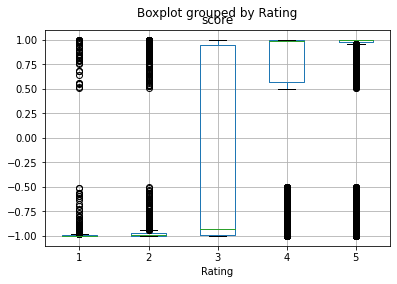

In [42]:
boxes = dat.boxplot(column='score', by='Rating')
boxes.plot()

### Segundo modelo para mapear entre Sentimiento y Rating.




In [15]:
from sklearn import tree
mytree = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=500, max_depth=5)
X = dat.score.array
X = X.reshape(-1, 1)
y = dat.Rating
mytree = mytree.fit(X, y)

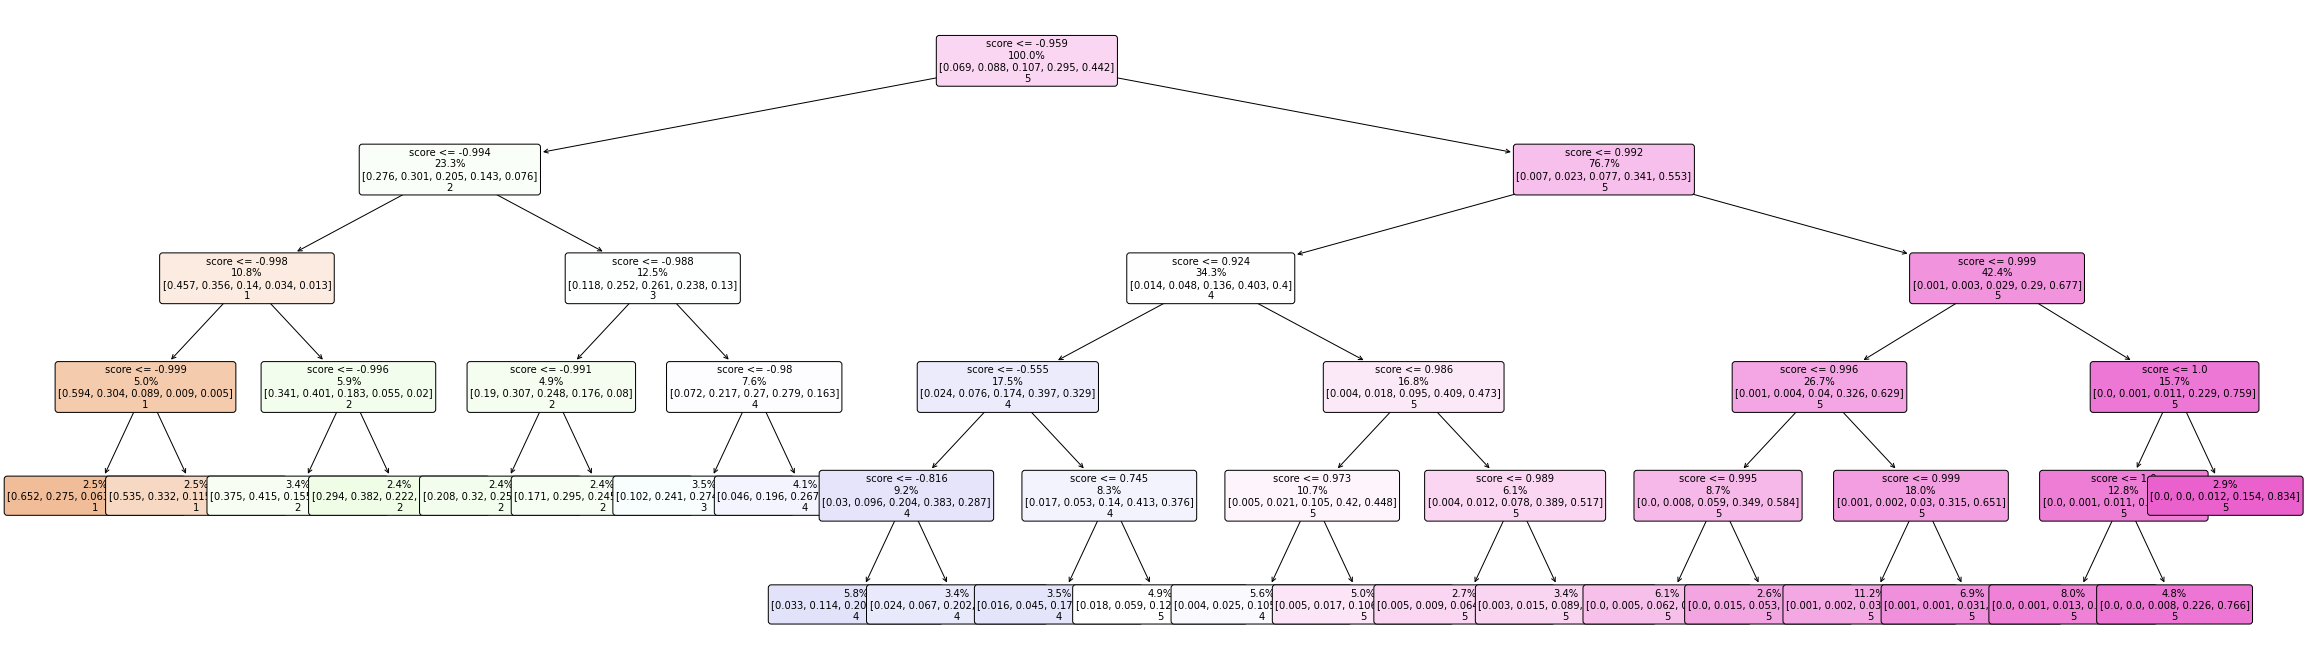

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 12))
tree.plot_tree(mytree, feature_names=['score'], class_names=['1','2','3','4','5'],
          label=False, impurity=False, fontsize=10, rounded=True, filled=True, proportion=True); 

In [72]:
#Propuesta basada en árbol de decisión
def score2labelv1(score):
  label = 5
  if (score<=-0.998): label = 1
  elif (score<=-0.988): label = 2
  elif (score<=-0.98): label = 3
  elif (score<=-0.959): label = 4
  elif (score<=0.745): label = 4
  elif (score<=0.924): label = 5
  elif (score<=0.973): label = 4
  elif (score>0.973): 5
  return(label)

#Propuesta basada en Quartiles
import numpy as np
for i in range(1,6):
  pscores = dat.loc[dat.Rating==i, 'score']
  (np.quantile(pscores, [0.25, 0.5, 0.75]))
def score2labelv2(score):
  label = 3
  if (score<=-0.99279857): label=1
  elif (score<=-0.97277617): label=2
  elif (score>-0.97277617 and score <=0.56545001): label=3
  elif (score>0.56545001 and score <0.98034751): label=4
  elif (score>0.98034751): label=5
  return(label)

def score2label(score):
  return(score2labelv2(score))

# Metricas desempeño de la propuesta final
La propuesta final es un modelo preentrenado para calcular de sentimiento, y luego un mapeo entre sentimiento y un puntaje entre 1 a 5.

Accuracy general: 0.497145088087453
Recall para clase 1 : 0.7494722026741731
Recall para clase 2 : 0.26882320133853876
Recall para clase 3 : 0.2522893772893773
Recall para clase 4 : 0.21510183805265773
Recall para clase 5 : 0.7499447757897062


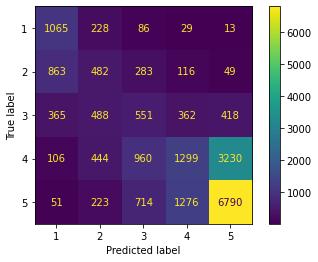

In [73]:
pred = dat.score.apply(score2label)
evalu = pd.DataFrame({'real':dat.Rating, 'pred':pred})

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(evalu.real, evalu.pred, labels=[1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()

print('Accuracy general:',sum(evalu.real == evalu.pred)/len(pred))
for i in range(1,6):
  part = evalu[evalu.real==i]
  prec = sum(part.real == part.pred)/len(part)
  print('Recall para clase', i, ':', prec)

#Conclusiones

1. El sentimiento negativo o positivo representado en una escala de -1 a 1 NO tiene una asociación lineal fuerte con los Reviews que son ordinales en una escala de 1 a 5.

- Esto puede deberse a que en el sentimiento solo tiene sentido los extremos, algo es positivo o negativo, pero no hay mucha familiaridad con un sentimiento neutro.

- Mientras que en los Reviews que son puntajes de 1 a 5, los valores intermedios si tienen sentido en cuanto a que no le gustó el hotel del todo, pero tampoco le disgustó.

---
2. Se opta por la solución donde el puntaje de sentimiento se particiona mediante Quartiles, para mapearlo a los Reviews, ya que tiene un mejor Recall de 74% para las clases extremas, es decir, los textos con sentimiento muy positivo son muy bien clasificados a un Review muy alto de 5, y los textos con sentimiento muy negativo son muy bien clasificados a un Review muy bajo de 1.

3. También se intentó hacer Fine-tuning de BERT con los datos de reviews de hoteles pero en la plataforma Google Colab dicho entrenamiento tardaba más de 10 horas y Colab no permite correr notebooks por más de 6 horas.

Se adjunta pantalla de ejercicio de fine-tuning
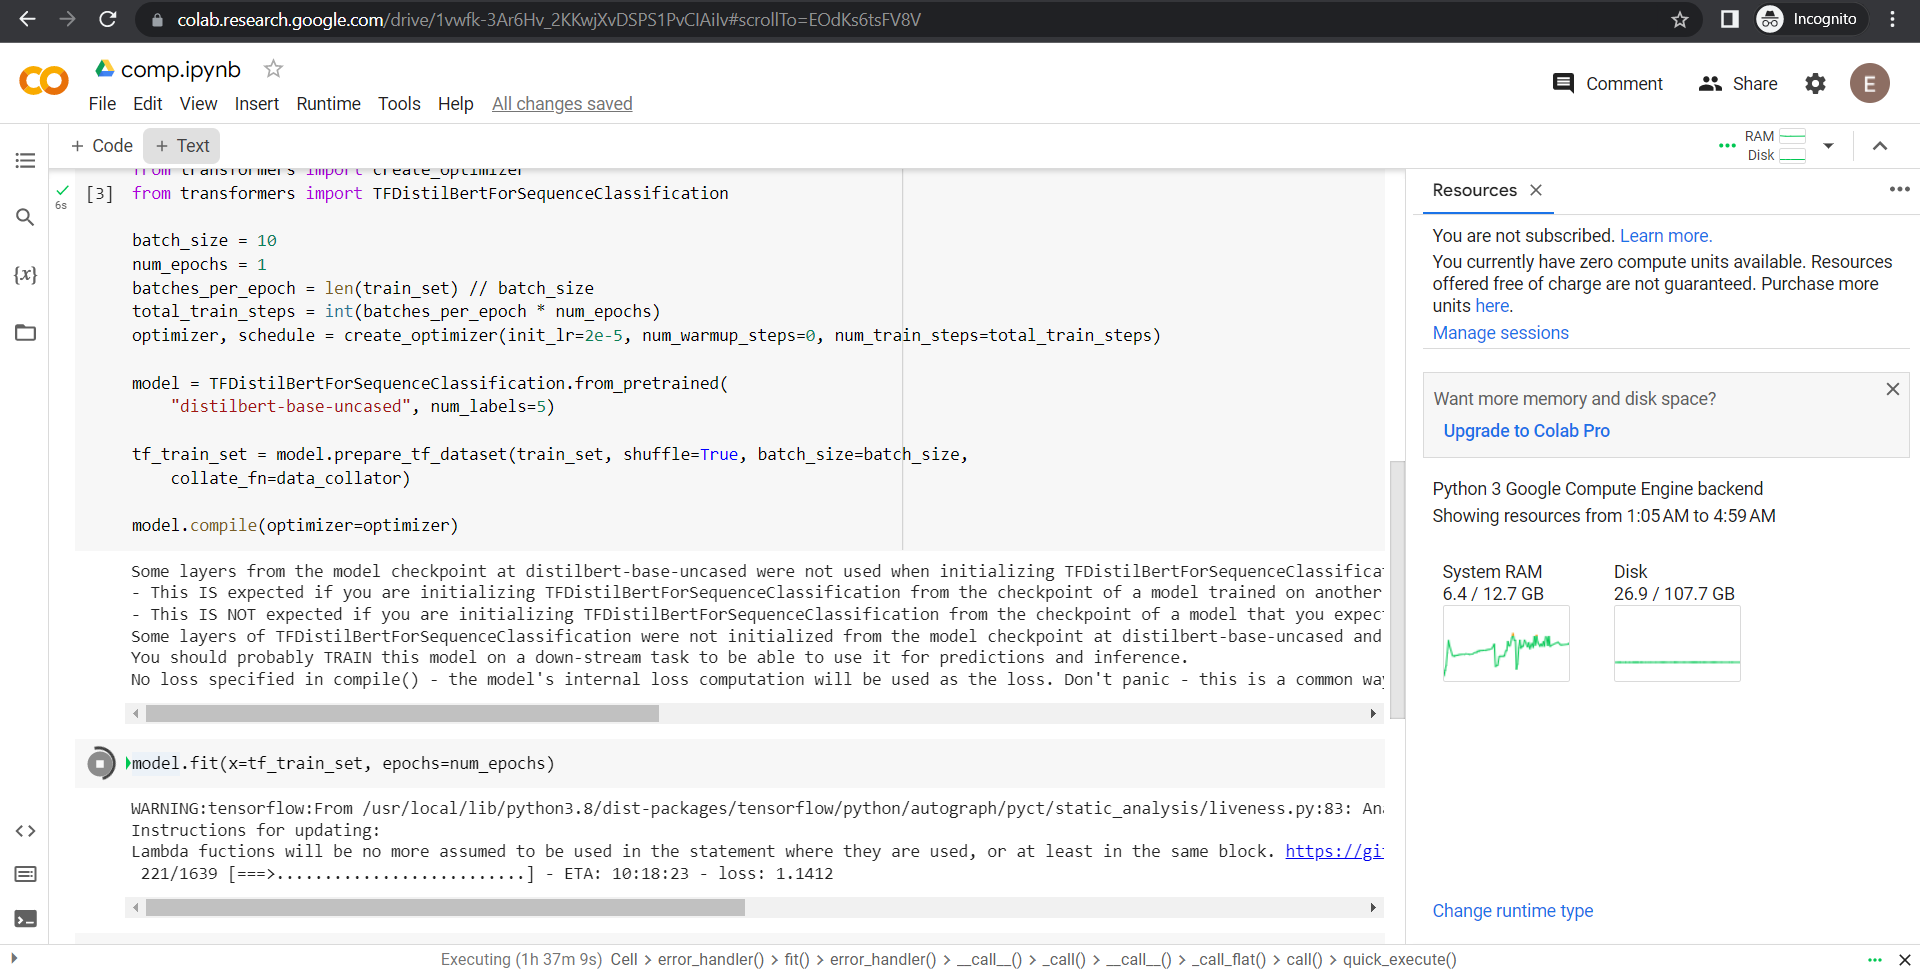